This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/8_Trees_Boosting/N1_Classif_tree.ipynb)

# CLASSIFICATION TREE
## Brief reminder
The goal is to create a model that predicts the value of a target variable based on several input variables. 

Each "internal" node of a tree corresponds to one of the input variables; there are edges to children for each of the possible values of that input variable. Each leaf represents a value of the target variable given the values of the input variables represented by the path from the root to the leaf.

A tree can be "learned" by splitting the source set into subsets based on an attribute value test. The "recursion" is completed when the subset at a node has all the same value of the target variable, or when splitting no longer adds value to the predictions (greedy algo).

As any multiway split may be summarized as a series of binary splits, the focus will be made on binary splits.

Splits are obtained by choosing a test at each step that "best" splits the set of items : What does mean Choosing the "best"  split $ S = S_r \cup S_l $ such that $ S_r \cap S_l = \emptyset $ for a test property $T$ ? An obvious heuristic is to choose the the query that decreases the impurity a much as possible.

## Metrics choice
### Gini impurity
Gini Impurity of a set **S** of cardinal *N* measures the probability that a randomly chosen element of the set would be incorrectly labeled if randomly labeled according to the label distribution in __S__.
$$ GI(S) = \sum_{k=1}^K P(y=k).P(y\neq k) = \sum_{k=1}^K P(y=k)[1-P(y = k)] = 1- \sum_{k=1}^K P^2(y=k)$$
then 
$$ \Delta GI(S) = GI(S) - P(S_l)GI(S_l) - (1-P(S_l))GI(S_r) $$
where $P(S_l) = \frac{N_l}{N}$ and $N_l + N_r = N$

### Entropy (Information)  impurity
$$ H(S) = -\sum_{k=1}^K P(y=k) \log_2 P(y=k) $$
the the information gain ($IG$) associated to the split (or partition)  $(S_l,S_r)$ is
$$ IG(S) = H(S) - H(S|(S_l,S_r)) = H(S) - P(S_l)H(S_l) - P(S_r)H(S_r)$$
where $H(S_l)$ (resp $H(S_r)$) are evaluated by using the empirical probabilities of the classes estimated from the subset $S_l$ (resp $S_r$)  : 
$$H(S_l) = -\sum_{k=1}^K P(y=k|X \in S_l) \log_2 P(y=k|X \in S_l)$$


## Splitting strategy
Designers usually choose to split wrt a single attribute. In general for non numerical attributes, an exhaustive search over all possibilities is performed. For real values attribute, gradient method for identifying a separating hyperplane may be used; However, simple threshold on a single attribute is often preferred. 

In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp

# Select random seed
random_state = None

## Generate training and test data using sklearn toy functions

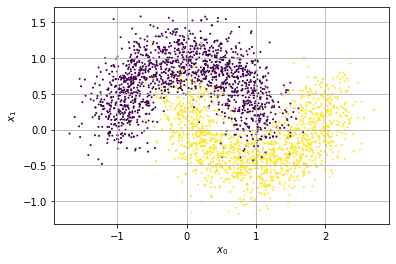

In [2]:
from sklearn.datasets import make_moons

# Note here that noise variance is set to 0.25
X, y = make_moons(n_samples=5000, random_state=random_state, noise=0.25)

from sklearn.model_selection import train_test_split

# We split the initial set in two sets: one, namely the training set, use for training the model,
# and one, namely the test set, use to compute the validation error
# -> test_size x n_samples for the test set and n_samples x (1- test_size) for the training set
# where test_size is given as a parameter
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=random_state
)

# Display the training set
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=1)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()

### Train a classification tree with predefined depth :

In [3]:
nbdepth = 4
My_tree = tree.DecisionTreeClassifier(max_depth=nbdepth, criterion="gini")

print(
    "resp. length of X_train and X_test are {0} and {1} ".format(
        [len(X_train)], [len(X_test)]
    )
)

My_tree = My_tree.fit(X_train, y_train)

resp. length of X_train and X_test are [3000] and [2000] 


For detailed explanations on the role of each input parameter, refer to [slearn documention](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

### Visualize the resulting Tree

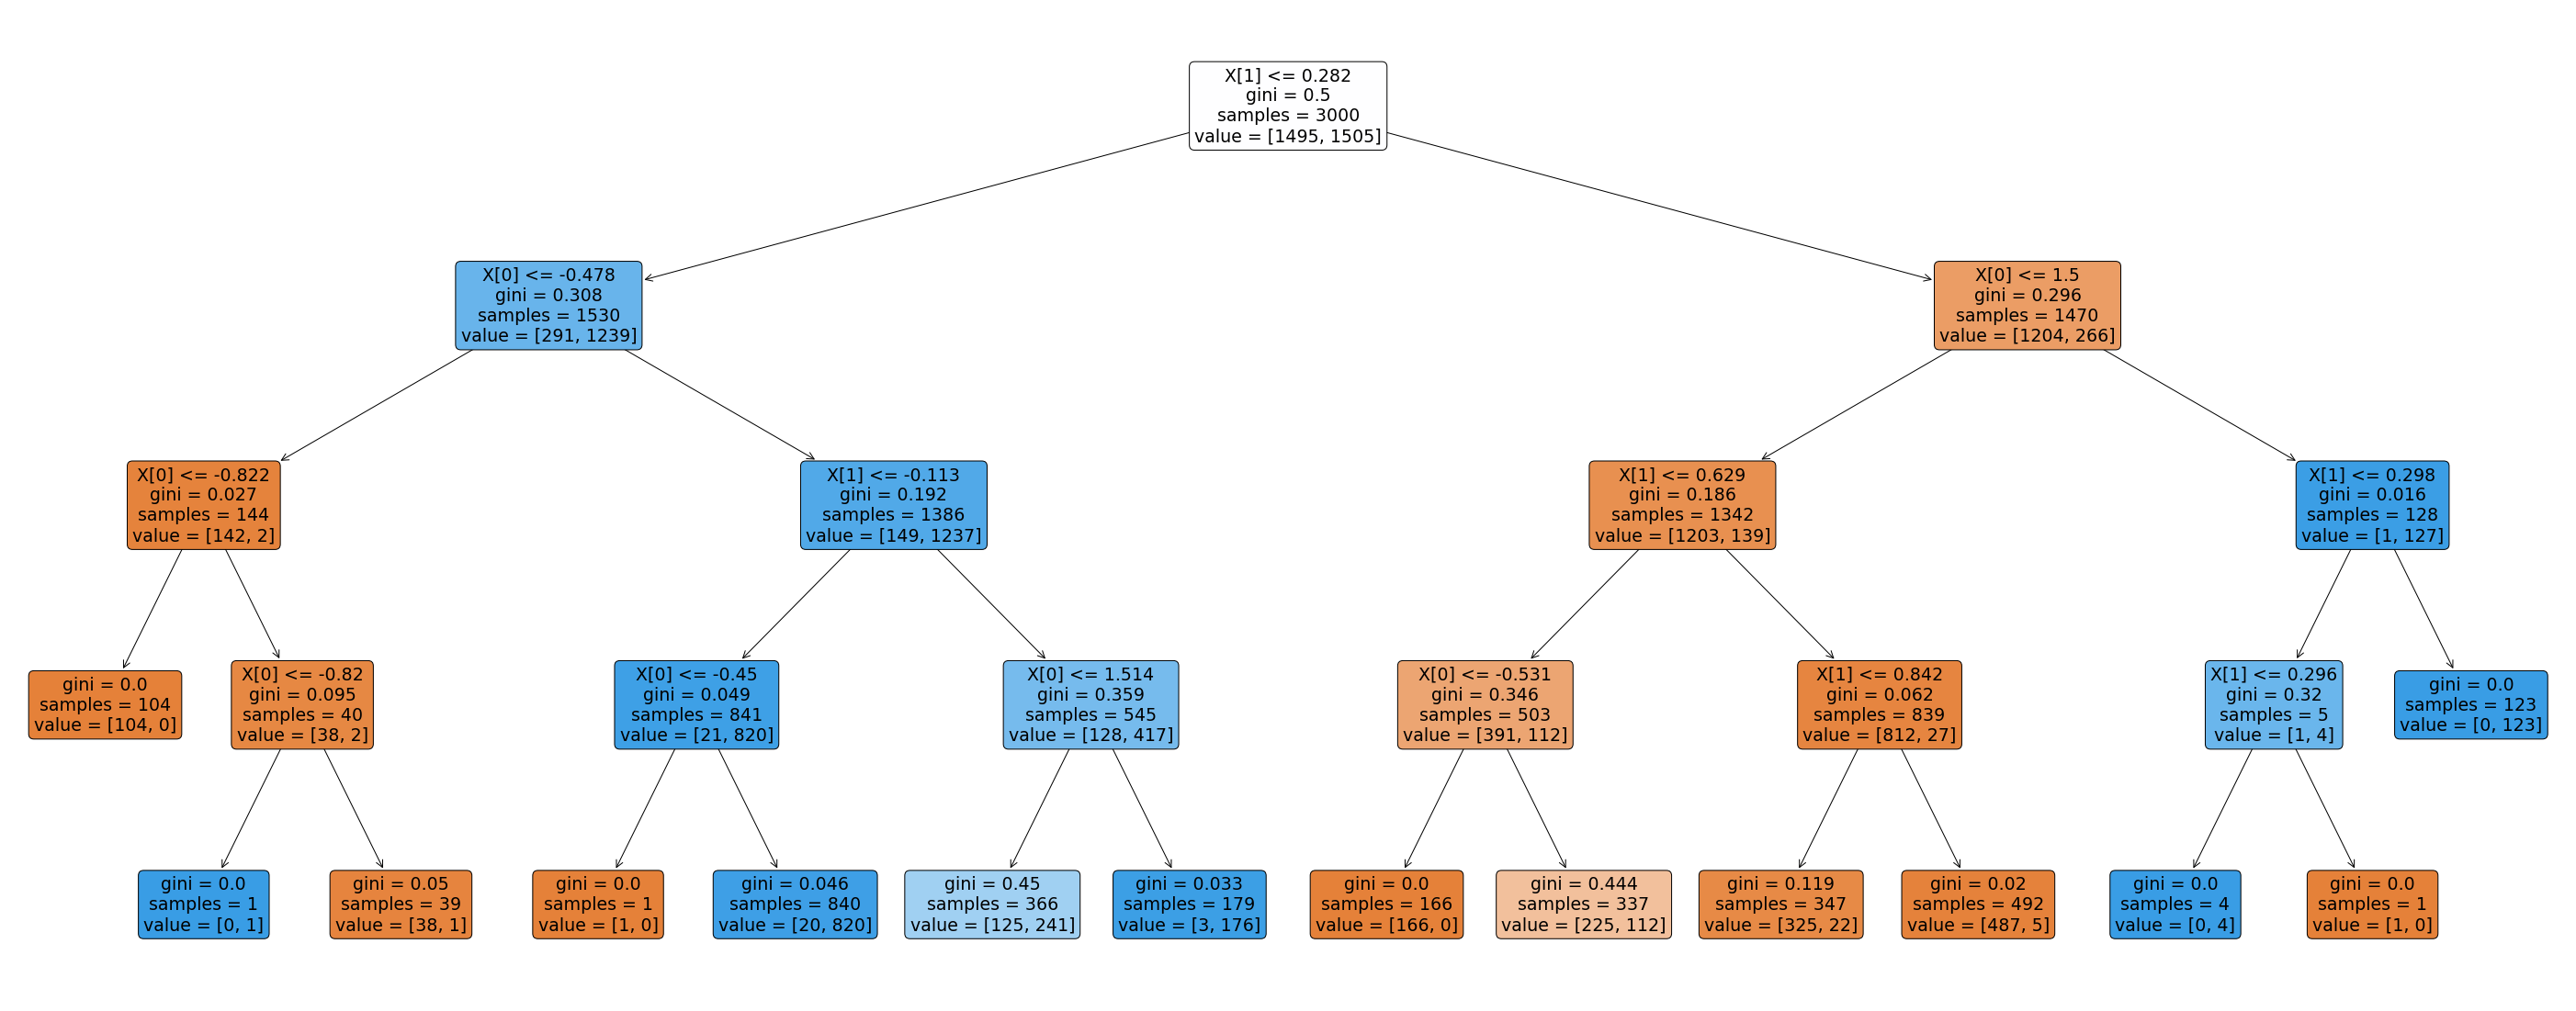

In [4]:
from sklearn.tree import plot_tree

plt.figure(figsize=(50, 20))
a = plot_tree(My_tree, filled=True, rounded=True)
# fontsize=14)

## Questions 1
* starting at a leaf and going up to the root node, is the evolution of the impurity index monotonic? 
* What is the impurity gain between the root node and its two children nodes? 
* Would the choice of a larger depth lead to a better classification tree? in which sense? 

### Plot of the the decision regions

/home/chatelaf/miniconda3/envs/calc/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, '$x_1$')

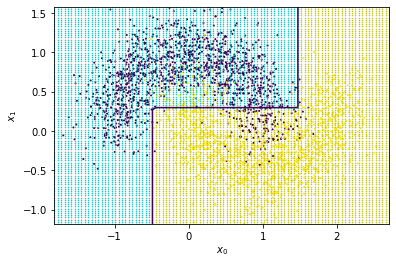

In [5]:
import numpy as np

XX, YY = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 100),
)
XY = np.vstack([XX.flatten(), YY.flatten()]).T
yp = My_tree.predict(XY)

plt.contour(XX, YY, yp.reshape(XX.shape), [0])
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, c=y_train)
plt.scatter(XY[yp == 0, 0], XY[yp == 0, 1], s=1, c="c", marker=".")
plt.scatter(XY[yp == 1, 0], XY[yp == 1, 1], s=1, c="y", marker=".")

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")

## Compute the Confusion matrices

A confusion matrix $C$ associated to a classifier that solves a $K$-class problem is defined by
$$ C_{i,j} = \mbox{Number of points classified with label $i$ while the true label is $j$ }$$ 

Below, two confusion matrices are proposed; The first one is constructed from the training set, the second is constructed from the test set. 

In [6]:
from sklearn import metrics

y_est = My_tree.predict(X_train)
print("Confusion matrix from training set :")
C_train = metrics.confusion_matrix(y_est, y_train)
print("C_train =\n {}".format(C_train))
print("accuracy= {}".format(metrics.accuracy_score(y_est, y_train)))

y_est = My_tree.predict(X_test)
print("Confusion matrix from test set :")
C_test = metrics.confusion_matrix(y_est, y_test)
print("C_test =\n {}".format(C_test))
print("accuracy= {}".format(metrics.accuracy_score(y_est, y_test)))

X_train

Confusion matrix from training set :
C_train =
 [[1347  140]
 [ 148 1365]]
accuracy= 0.904
Confusion matrix from test set :
C_test =
 [[910  87]
 [ 95 908]]
accuracy= 0.909


array([[ 1.59710503, -0.44777444],
       [ 0.58878906,  0.34176797],
       [-0.76535261,  0.66393913],
       ...,
       [ 1.35843857, -0.42447771],
       [ 2.06821779,  0.36591726],
       [ 1.92035768,  0.13161492]])

## Questions 2
* Which of these two matrices is the more relavant for characterizing the classifier? 
* What does the accuracy represent?
* Is such an accuracy estimate on a single experiment reliable? 

## Evaluate the score of the Classification Tree approach, using cross validation

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=None)
scores = cross_val_score(My_tree, X, y, cv=cv)
print(
    "Mean Accuracy and 95 percent confidence interval : %0.2f (+/- %0.2f)"
    % (scores.mean(), scores.std() * 2)
)

Mean Accuracy and 95 percent confidence interval : 0.91 (+/- 0.01)


## Model complexity
An important hyperparameter in the tree classifier construction is related to the stopping criterion. In the study above, the maximal depth (parameter nbdepth) is fixed by the user. Here, it is proposed to test the accuracy as a function of nbdepth.

[0.90252, 0.89984, 0.8990000000000002, 0.9282800000000002, 0.93232, 0.92904, 0.92384, 0.9210799999999999, 0.92012, 0.9169199999999998, 0.9151999999999999]


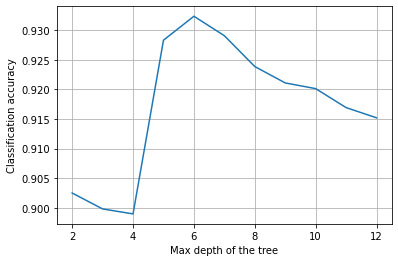

In [8]:
depth_array = np.arange(2, 13)
estd_accuracy = []

cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=None)

for nbdepth in depth_array:
    clf = tree.DecisionTreeClassifier(max_depth=nbdepth, criterion="gini")
    scores = cross_val_score(clf, X, y, cv=cv)
    estd_accuracy.append(scores.mean())

print(estd_accuracy)

plt.plot(depth_array, estd_accuracy)
plt.xlabel("Max depth of the tree")
plt.ylabel("Classification accuracy")
plt.grid()

## Exercice 3
* From the set of experiments and results above, set the optimal value nbdepth for noise=.4. 
* Run the code for a high value of the maximal depth parameter. What do you observe? Explain
* If the noise variance is set to zero (noise=0.) and nbdepth to a high value, explain why the tree growing is stopped before the max depth is reached. 
* Change the noise variance to a higher value. how does the optimal value of the depth evolve? Comment.  